### Simulation of cavity response to readout pulses

In [1]:
# Import python libraries

from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define circuit parameters 

# Define number of fock states in resonator
N = 10

# Circuit parameters
wr = 7.062 * 2 * np.pi      # Resonator frequency (7.062 GHz)
wq = 5.092 * 2 * np.pi      # Qubit frequency (5.092 GHz)
delta = abs(wr - wq)        # Detuning between qubit and resonator (1.97 GHz)
k = 0.00535 * 2 * np.pi     # Resonator decay rate (5.35 MHz)
g = 0.1029 * 2 * np.pi      # Coupling strength (102.9 MHz)
gamma = 0.001 * 2 * np.pi   # Qubit decay (1 MHz)

wr_d = wr - g**2 / delta    # Dressed resonator frequency (9.9997GHz)
wq_d = wq + g**2 / delta    # Dressed qubit frequency (5.0003GHz)

K = (2* g**4 * (3 * wq**4 + 2 * wq**2 * wr**2 + 3 * wr**4))/((wq**2 - wr**2)**4)       # Kerr self-nonlinearity (1.31KHz)
chi = 0.16 * k              # Dispersive shift, cross non-linearity (0.856 MHz)
alpha = 0.175 * 2 * np.pi   # Anharmonity (175 MHz)

n_crit = (delta / 2*g)**2  # Critical photon number (16)

# Define quantum operators
a = tensor(destroy(N), qeye(2))    # Resonator lowering operator
q = tensor(qeye(N), destroy(2))    # Qubit lowering operator
sz = tensor(qeye(N), sigmaz())     # Qubit sigma_z

# Base Hamiltonian without drive: 
H0 = wq * q.dag() * q + wr * a.dag() * a  - alpha/2 * q.dag() * q.dag() * q * q - K/2 * a.dag() * a.dag() * a * a - g * (a + a.dag()) * (q + q.dag())  # Dispersive Hamiltonian

# H0 = wq_d * sz/2 + wr_d * a.dag() * a - chi * a.dag() * a * sz  # Dispersive Hamiltonian

# H0 = wr * a.dag() * a + (wq + 2 * chi * (a.dag() * a + 1/2)) * sz / 2  # Base  Hamiltonian
# HK = K * (a.dag() * a.dag() * a * a)  # Kerr term
# H_steady = H0 + HK  # Steady state Hamiltonian

# Define collapse operators
c_ops = [np.sqrt(k) * a]  # Resonator decay

# Define measurement operators
e_ops = [a.dag() * a, a]  # Photon number in resonator and qubit state, resonator field

# Initial state: resonator in vacuum, qubit in ground state
psi0 = tensor(basis(N, 0), basis(2,0))  # Vacuum state for resonator, ground state for qubit
psi4 = tensor(coherent(N, 4), basis(2,0))  # Coherent state (eigenvalue 4) for resonator, ground state for qubit

# Time evolution parameters
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns


In [69]:
# Find the drive power needed to inject 1 photon into the resonator

def find_drive_power(target_photon_number, tolerance=0.01):
    """Find the drive power needed to inject a specific photon number into the resonator."""
    power = 0.001 * 2 * np.pi
    step = 0.01 * 2 * np.pi  # Initial step size for power
    while True:
        # Define the drive Hamiltonian with the current power
        def drive_pulse_1(t, args):
            return np.sqrt(power) * np.exp(-1j * wr * t)
        def drive_pulse_2(t, args):
            return np.sqrt(power) * np.exp(1j * wr * t)
        HD1 = [a.dag() * 1j * np.sqrt(k), drive_pulse_1]
        HD2 = [a * -1j * np.sqrt(k), drive_pulse_2]
        H = [H0, HD1, HD2]  # Total Hamiltonian with drive
        tlist = np.linspace(0, 800, 800)  # Time from 0 to 800 ns

        # Calculate the steady state
        steady_state = mesolve(H, psi0, tlist, c_ops).states[-1]
        n_expt = expect(a.dag() * a, steady_state)
        q_expt = expect(q.dag() * q, steady_state)
        print(f"Steady state photon number: {n_expt:.2f}, with drive power: {power / (2 * np.pi):.5f} GHz")

        if abs(n_expt - target_photon_number) < tolerance:
            break
        
        if n_expt < target_photon_number:
            power += step  # Increase power if we need more photons
        else:
            power -= step  # Decrease power if we have too many photons
        
        step /= 2  # Reduce step size for finer tuning
    
    return power, q_expt

# Find the drive power to inject 1 photon into the resonator
target_photon_number = 1
drive_power, qubit_state = find_drive_power(target_photon_number)
print(f"Drive power needed to inject {target_photon_number} photon(s): {drive_power / (2 * np.pi)} GHz")
print (f"Qubit state expectation value: {qubit_state}")

Steady state photon number: 0.20, with drive power: 0.00 GHz
Steady state photon number: 2.17, with drive power: 0.01 GHz
Steady state photon number: 1.18, with drive power: 0.01 GHz
Steady state photon number: 0.69, with drive power: 0.00 GHz
Steady state photon number: 0.93, with drive power: 0.00 GHz
Steady state photon number: 1.06, with drive power: 0.01 GHz
Steady state photon number: 0.99, with drive power: 0.01 GHz
Drive power needed to inject 1 photon(s): 0.0050625 GHz
Qubit state expectation value: 0.005601704612860106


In [3]:
drive_power = 0.0050625 * 2 * np.pi

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


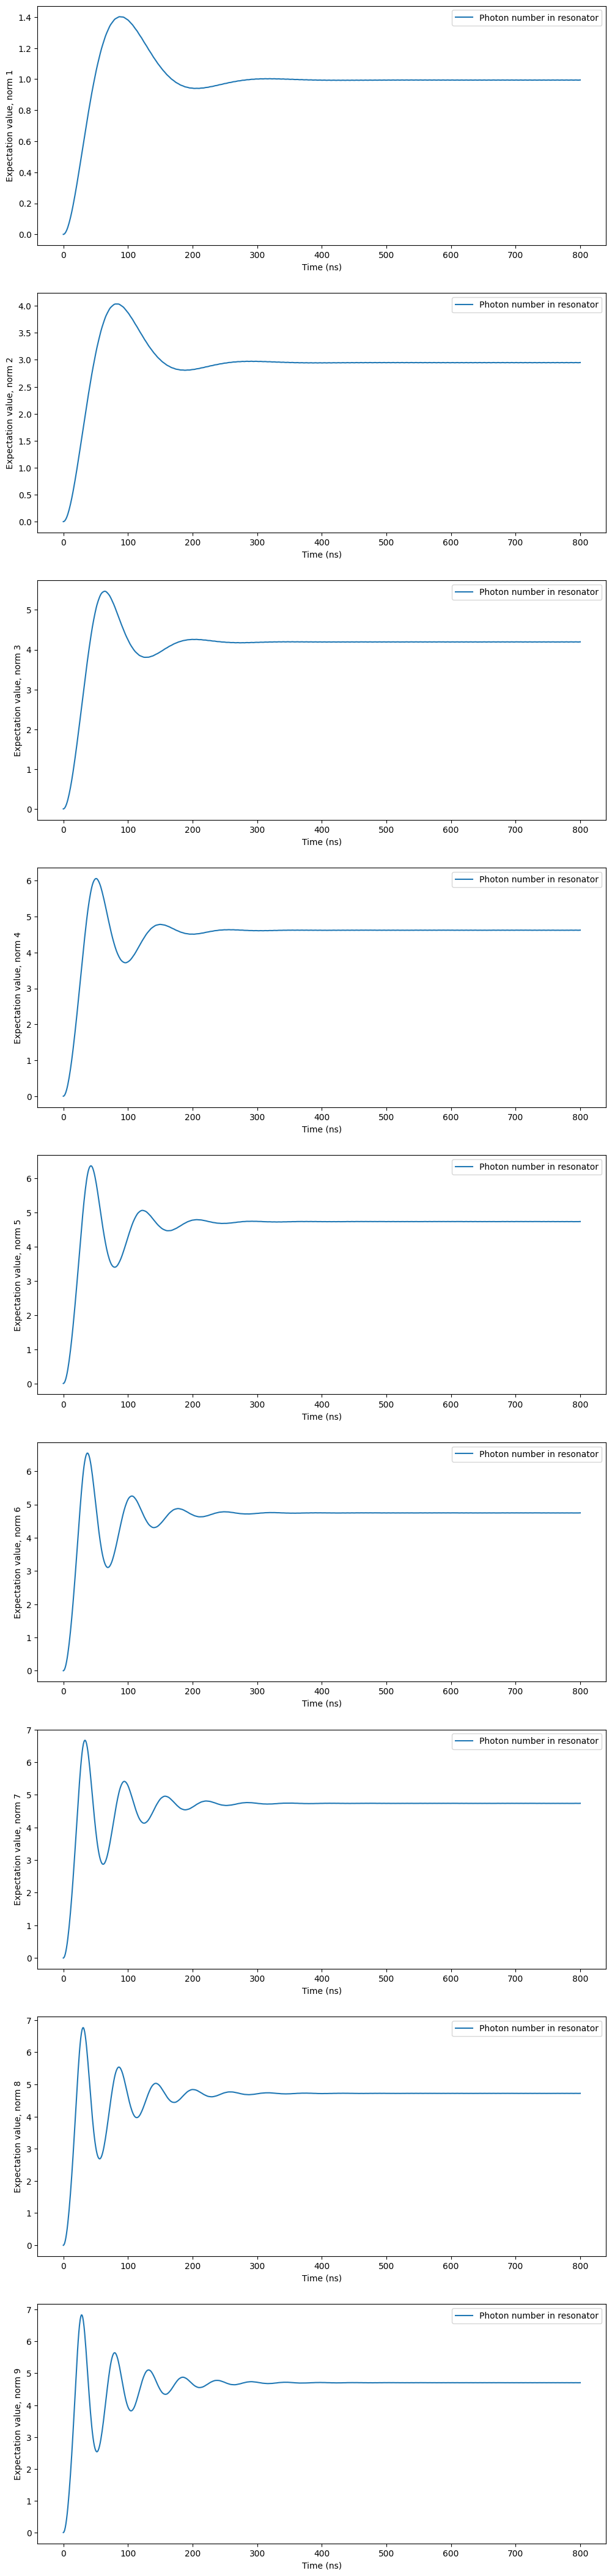

In [71]:
norm = 1
N_plots = 10
plt.figure(figsize=(12, 60))

for i in range(1, N_plots):
    def drive_pulse_1(t, args):
        return np.sqrt(norm * drive_power) * np.exp(-1j * wr * t)
    def drive_pulse_2(t, args):
        return np.sqrt(norm * drive_power) * np.exp(1j * wr * t)
    HD1 = [a.dag() * 1j * np.sqrt(k), drive_pulse_1]
    HD2 = [a * -1j * np.sqrt(k), drive_pulse_2]
    H = [H0, HD1, HD2]  # Total Hamiltonian with drive
    tlist = np.linspace(0, 800, 800)  # Time from 0 to 800 ns

    # Calculate the steady state
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]
    norm += 2

    plt.subplot(N_plots, 1, i)
    plt.plot(tlist, expectation_values[0], label='Photon number in resonator')
    plt.xlabel('Time (ns)')
    plt.ylabel(f'Expectation value, norm {i}')
    plt.legend()


In [63]:
def find_steady_state_time(tlist, photon_number, threshold=1e-2, window_size=500):
    photon_number = np.array(photon_number)
    tlist = np.array(tlist)

    for i in range(len(photon_number) - window_size):
        window = photon_number[i:i + window_size]
        if np.max(window) - np.min(window) < threshold:
            return tlist[i]
    
    return None

def find_cavity_reset_time(tlist, photon_number, threshold=1e-3):
    photon_number = np.array(photon_number[5000:])
    tlist = np.array(tlist)

    below_threshold = np.where(photon_number <= threshold)[0]
    if len(below_threshold) > 0:
        return tlist[below_threshold[0] + 5000] - 500
    else:
        return None

/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


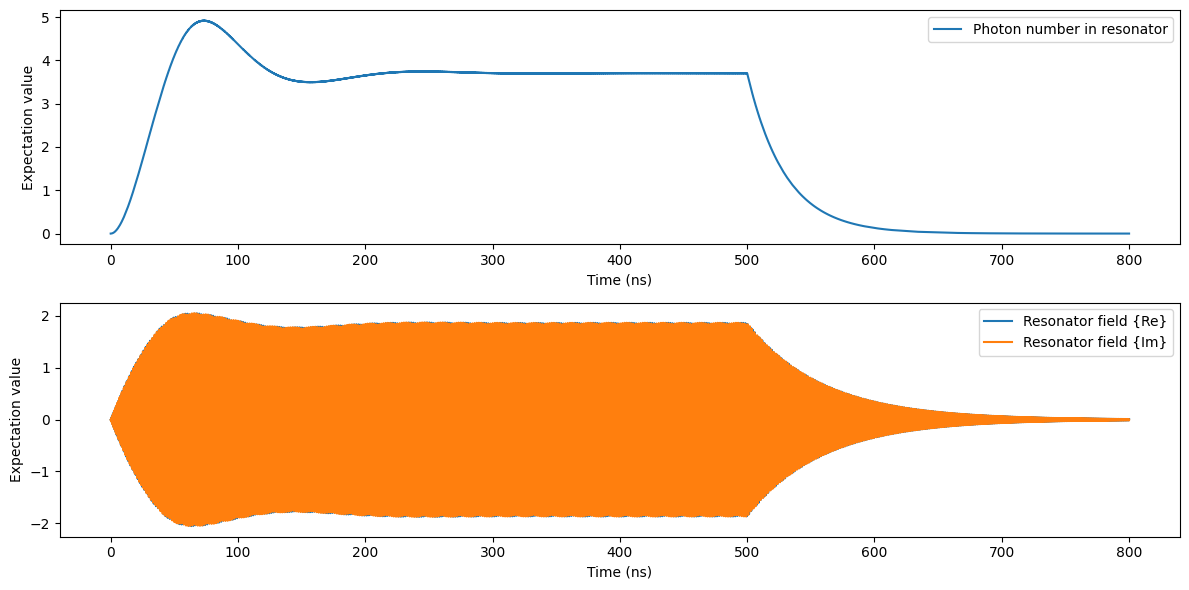

In [4]:
# First, define rectangle pulse as the drive pulse
norm = 4
drive_amp = np.sqrt(norm * drive_power)  # Amplitude of the drive pulse
def drive_pulse_1(t, args):
    return drive_amp * np.exp(-1j * wr * t)  if t <= 500 else 0  # Pulse from 100 ns to 200 ns

def drive_pulse_2(t, args):
    return drive_amp * np.exp(1j * wr * t)  if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD1 = [a.dag() * 1j * np.sqrt(k), drive_pulse_1]
HD2 = [a * -1j * np.sqrt(k), drive_pulse_2]
H = [H0, HD1, HD2]  # Total Hamiltonian with drive

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, np.real(expectation_values[1]), label='Resonator field {Re}')
plt.plot(tlist, np.imag(expectation_values[1]), label='Resonator field {Im}')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
# Determine steady state time and reset time for a rectangle pulse
steady_state_time = find_steady_state_time(tlist, expectation_values[0])
reset_time = find_cavity_reset_time(tlist, expectation_values[0])
print(f"Rectangle Pulse Steady state duration: {steady_state_time} ns")
print(f"Rectangle Pulse Cavity reset duration: {reset_time} ns")

Rectangle Pulse Steady state duration: 306.5383172896612 ns
Rectangle Pulse Cavity reset duration: 247.493436679585 ns


/home/spinoandraptos/py_envs/qt_venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


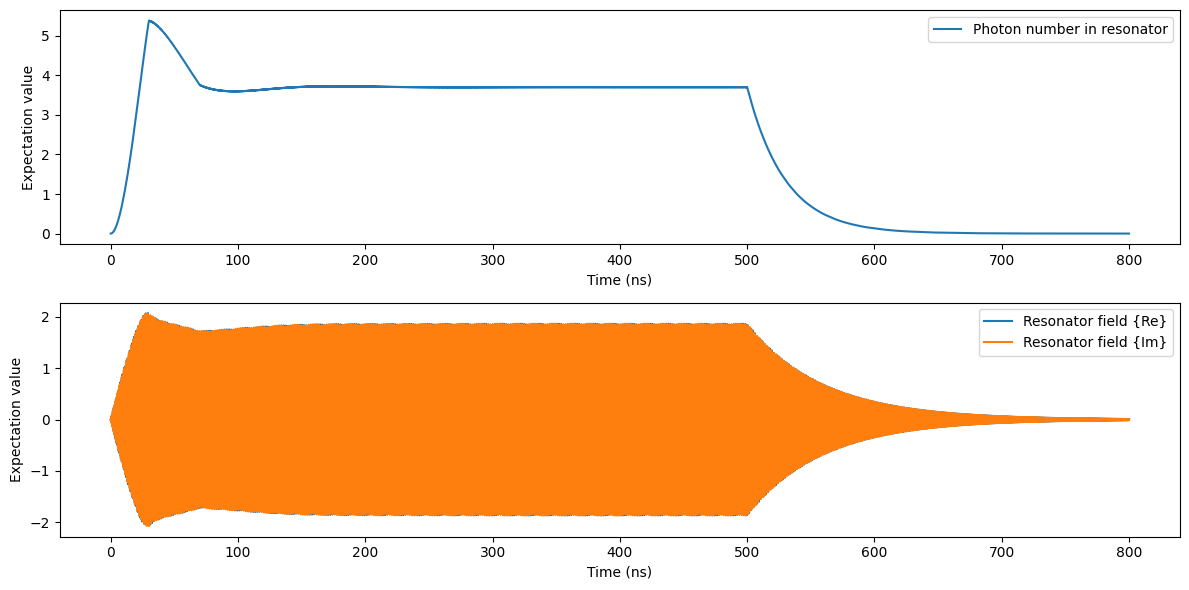

In [67]:
ringup_norm = 10
drive_norm = 4
ringdown_norm = 2
ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
ringdown_amp = np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

def drive_pulse_1(t, args):
    if t<=30:
        return ringup_amp * np.exp(-1j * wr * t)
    elif t <= 70:
        return ringdown_amp * np.exp(-1j * wr * t)
    elif t <= 500:
        return drive_amp * np.exp(-1j * wr * t)
    else:   
        return 0.0

def drive_pulse_2(t, args):
    if t<=30:
        return ringup_amp * np.exp(1j * wr * t)
    elif t <= 70:
        return ringdown_amp * np.exp(1j * wr * t)
    elif t <= 500:
        return drive_amp * np.exp(1j * wr * t)
    else:   
        return 0.0
    
HD1 = [a.dag() * 1j * np.sqrt(k), drive_pulse_1]
HD2 = [a * -1j * np.sqrt(k), drive_pulse_2]
H = [H0, HD1, HD2]  # Total Hamiltonian with drive

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, np.real(expectation_values[1]), label='Resonator field {Re}')
plt.plot(tlist, np.imag(expectation_values[1]), label='Resonator field {Im}')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Determine steady state time and reset time for a rectangle pulse
steady_state_time = find_steady_state_time(tlist, expectation_values[0])
reset_time = find_cavity_reset_time(tlist, expectation_values[0])
print(f"Ringup Pulse Steady state duration: {steady_state_time} ns")
print(f"Ringup Pulse Cavity reset duration: {reset_time} ns")

Rectangle Pulse Steady state duration: 230.42880360045007 ns
Rectangle Pulse Cavity reset duration: 247.493436679585 ns


Steady state reached at around 150ns

In [ ]:
def simulate_populate(ringup_time, ringdown_time):
    ringup_norm = 10
    drive_norm = 4
    ringdown_norm = 2
    ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown_amp = np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse_1(t, args):
        if t<=ringup_time:
            return ringup_amp * np.exp(-1j * wr * t)
        elif t <= ringup_time + ringdown_time:
            return ringdown_amp * np.exp(-1j * wr * t)
        elif t <= 500:
            return drive_amp * np.exp(-1j * wr * t)
        else:   
            return 0.0

    def drive_pulse_2(t, args):
        if t<=ringup_time:
            return ringup_amp * np.exp(1j * wr * t)
        elif t <= ringup_time + ringdown_time:
            return ringdown_amp * np.exp(1j * wr * t)
        elif t <= 500:
            return drive_amp * np.exp(1j * wr * t)
        else:   
            return 0.0
        
    HD1 = [a.dag() * 1j * np.sqrt(k), drive_pulse_1]
    HD2 = [a * -1j * np.sqrt(k), drive_pulse_2]
    H = [H0, HD1, HD2]  # Total Hamiltonian with drive

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

    return expectation_values

Optimal ring-up time: 25 ns, ring-down time: 45 ns, stabilization time: 168.62107763470433 ns


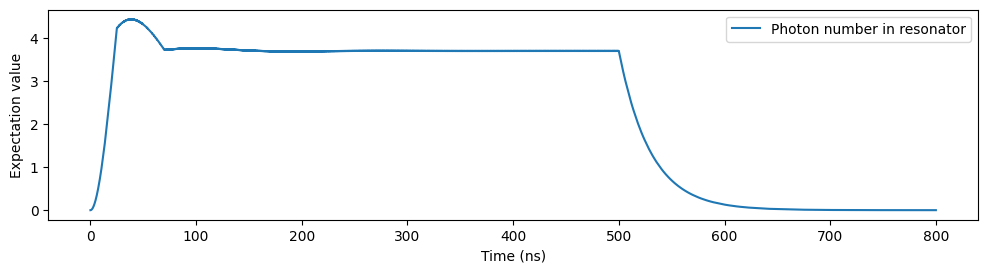

In [ ]:
# Optimise the ringup and ringdown times to arrive the fastest at steady state
ringup_times = np.arange(20, 50, 5)  # Ring-up times from 5 to 100 ns
ringdown_times = np.arange(20, 50, 5)
stabilization_times = []
for ringup in ringup_times:
    for ringdown in ringdown_times:

        # Extract the expectation values
        expectation_values = simulate_populate(ringup, ringdown)

        # Find stabilization time
        stabilization_time = find_steady_state_time(tlist, expectation_values[0])
        stabilization_times.append((ringup, ringdown, stabilization_time, expectation_values))
# Find the optimal ring-up and ring-down times
optimal = min(stabilization_times, key=lambda x: (x[2] is not None, x[2]))
print(f"Optimal ring-up time: {optimal[0]} ns, ring-down time: {optimal[1]} ns, stabilization time: {optimal[2]} ns")
# Plot the results for the optimal ring-up and ring-down times
optimal_expectation_values = optimal[3]
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(tlist, optimal_expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()
plt.show()

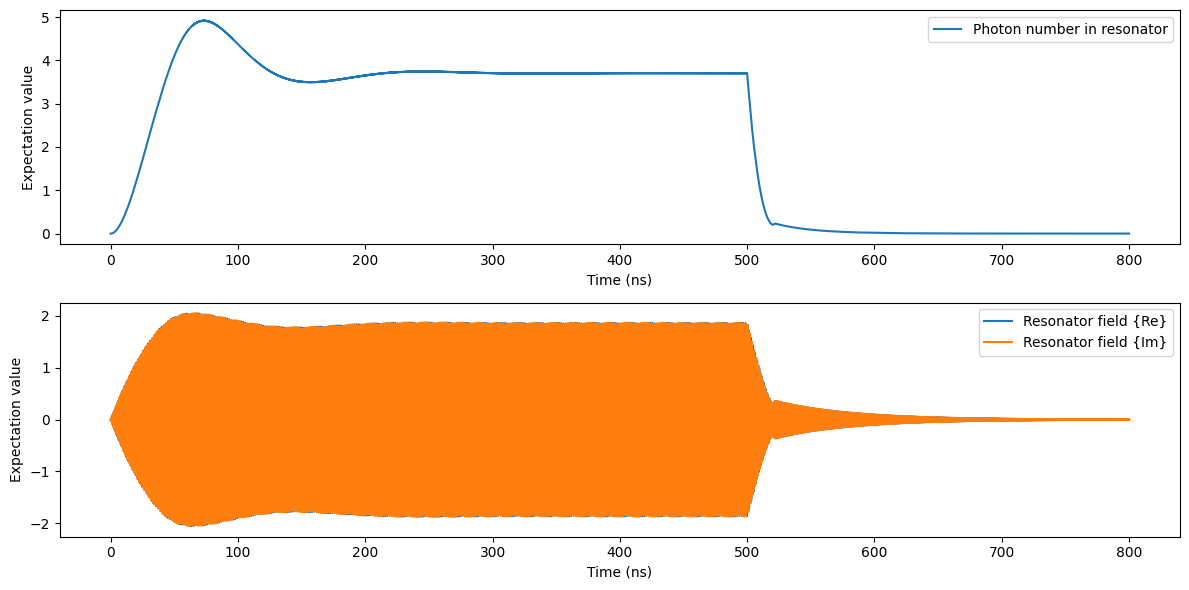

In [73]:
# First, define rectangle pulse as the drive pulse
drive_power = 0.0050625 * 2 * np.pi
ringup_norm = 1
drive_norm = 4
ringdown_norm = 6
ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
ringdown_amp = -np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

def drive_pulse_1(t, args):
    if t<=500:
        return drive_amp * np.exp(-1j * wr * t)
    elif t <= 520:
        return ringdown_amp * np.exp(-1j * wr * t - 1j * np.pi/2)  # Phase shift for ring-down pulse
    elif t <= 522:
        return ringup_amp * np.exp(-1j * wr * t)
    else:   
        return 0.0

def drive_pulse_2(t, args):
    if t<=500:
        return drive_amp * np.exp(1j * wr * t)
    elif t <= 520:
        return ringdown_amp * np.exp(1j * wr * t + 1j * np.pi/2)  # Phase shift for ring-down pulse
    elif t <= 522:
        return ringup_amp * np.exp(1j * wr * t)
    else:   
        return 0.0
    
HD1 = [a.dag() * 1j * np.sqrt(k), drive_pulse_1]
HD2 = [a * -1j * np.sqrt(k), drive_pulse_2]
H = [H0, HD1, HD2]  # Total Hamiltonian with drive

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tlist, np.real(expectation_values[1]), label='Resonator field {Re}')
plt.plot(tlist, np.imag(expectation_values[1]), label='Resonator field {Im}')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Determine steady state time and reset time for a rectangle pulse
steady_state_time = find_steady_state_time(tlist, expectation_values[0])
reset_time = find_cavity_reset_time(tlist, expectation_values[0])
print(f"Ringdown Pulse Steady state duration: {steady_state_time} ns")
print(f"Ringdown Pulse Cavity reset duration: {reset_time} ns")

Rectangle Pulse Steady state duration: 306.5383172896612 ns
Rectangle Pulse Cavity reset duration: 186.68583572946625 ns


In [76]:
def simulate_reset(ringup_time, ringdown_time):
    # First, define rectangle pulse as the drive pulse
    drive_power = 0.0050625 * 2 * np.pi
    ringup_norm = 1
    drive_norm = 4
    ringdown_norm = 6
    ringup_amp = np.sqrt(ringup_norm * drive_power)  # Amplitude of the ring-up pulse
    drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
    ringdown_amp = -np.sqrt(ringdown_norm * drive_power)  # Amplitude of the ring-down pulse

    def drive_pulse_1(t, args):
        if t<=500:
            return drive_amp * np.exp(-1j * wr * t)
        elif t <= 500 + ringdown_time:
            return ringdown_amp * np.exp(-1j * wr * t - 1j * np.pi/2)  # Phase shift for ring-down pulse
        elif t <= 500 + ringdown_time + ringup_time:
            return ringup_amp * np.exp(-1j * wr * t)
        else:   
            return 0.0

    def drive_pulse_2(t, args):
        if t<=500:
            return drive_amp * np.exp(1j * wr * t)
        elif t <= 500 + ringdown_time:
            return ringdown_amp * np.exp(1j * wr * t + 1j * np.pi/2)  # Phase shift for ring-down pulse
        elif t <= 500 + ringdown_time + ringup_time:
            return ringup_amp * np.exp(1j * wr * t)
        else:   
            return 0.0
        
    HD1 = [a.dag() * 1j * np.sqrt(k), drive_pulse_1]
    HD2 = [a * -1j * np.sqrt(k), drive_pulse_2]
    H = [H0, HD1, HD2]  # Total Hamiltonian with drive

    # Calculate the expectation values of the measurement operators
    tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
    expectations = mesolve(H, psi0, tlist, c_ops, e_ops)

    # Extract the expectation values
    expectation_values = [expectations.expect[i] for i in range(len(e_ops))]

    return expectation_values

Optimal ring-up time: 1 ns, ring-down time: 21 ns, reset time: 183.4854356794599 ns


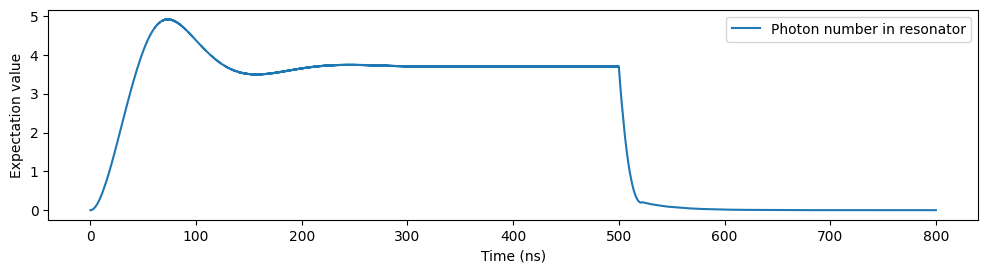

In [82]:
# Optimise the ringup and ringdown times to arrive the fastest at steady state
ringup_times = np.arange(1, 25, 2)  # Ring-up times from 5 to 100 ns
ringdown_times = np.arange(1, 25, 2)
reset_times = []
for ringup in ringup_times:
    for ringdown in ringdown_times:

        # Extract the expectation values
        expectation_values = simulate_reset(ringup, ringdown)

        # Find stabilization time
        reset_time = find_cavity_reset_time(tlist, expectation_values[0])
        reset_times.append((ringup, ringdown, reset_time, expectation_values))
# Find the optimal ring-up and ring-down times
optimal = min(reset_times, key=lambda x: (x[2] is not None, x[2]))
print(f"Optimal ring-up time: {optimal[0]} ns, ring-down time: {optimal[1]} ns, reset time: {optimal[2]} ns")
# Plot the results for the optimal ring-up and ring-down times
optimal_expectation_values = optimal[3]
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(tlist, optimal_expectation_values[0], label='Photon number in resonator')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()
plt.show()

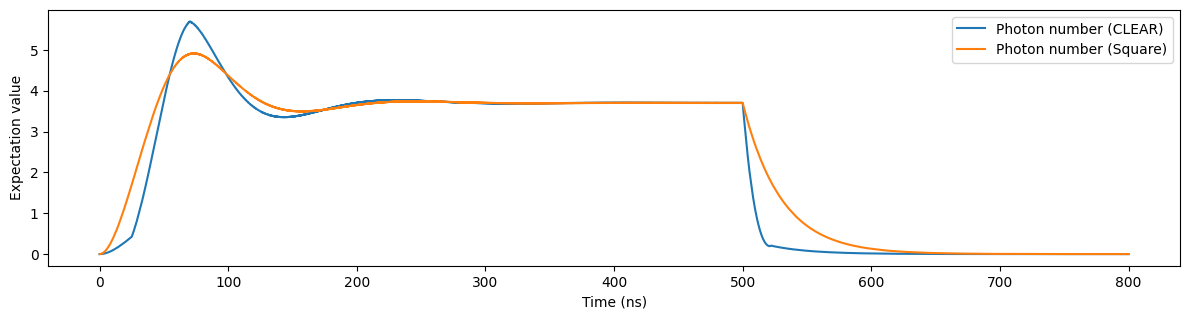

In [ ]:
# Full CLEAR signal and photon response
drive_power = 0.0050625 * 2 * np.pi

ringup1_norm = 10
ringdown1_norm = 2
ringup1_amp = np.sqrt(ringup1_norm * drive_power)  # Amplitude of the ring-up pulse
ringdown1_amp = np.sqrt(ringdown1_norm * drive_power)  # Amplitude of the ring-down pulse

ringup2_norm = 1
drive_norm = 4
ringdown2_norm = 6
ringup2_amp = np.sqrt(ringup2_norm * drive_power)  # Amplitude of the ring-up pulse
drive_amp = np.sqrt(drive_norm * drive_power)  # Amplitude of the drive pulse
ringdown2_amp = -np.sqrt(ringdown2_norm * drive_power)  # Amplitude of the ring-down pulse

optimal_ringup1_time = 25
optimal_ringdown1_time = 45
optimal_ringup2_time = 1
optimal_ringdown2_time = 21


def CLEAR_drive_pulse_1(t, args):
    if t<=optimal_ringup1_time:
        return ringup1_amp * np.exp(-1j * wr * t)
    elif t <= optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp * np.exp(-1j * wr * t)
    elif t <= 500:
        return drive_amp * np.exp(-1j * wr * t)
    elif t <= 500 + optimal_ringdown2_time:
        return ringdown2_amp * np.exp(-1j * wr * t - 1j * np.pi/2)  # Phase shift for ring-down pulse
    elif t <= 500 + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp * np.exp(-1j * wr * t)
    else:   
        return 0.0

def CLEAR_drive_pulse_2(t, args):
    if t<=optimal_ringup1_time:
        return ringup1_amp * np.exp(1j * wr * t)
    elif t <= optimal_ringup1_time + optimal_ringdown1_time:
        return ringdown1_amp * np.exp(1j * wr * t)
    elif t <= 500:
        return drive_amp * np.exp(1j * wr * t)
    elif t <= 500 + optimal_ringdown2_time:
        return ringdown2_amp * np.exp(1j * wr * t + 1j * np.pi/2)  # Phase shift for ring-down pulse
    elif t <= 500 + optimal_ringdown2_time + optimal_ringup2_time:
        return ringup2_amp * np.exp(1j * wr * t)
    else:   
        return 0.0

def square_drive_pulse_1(t, args):
    return drive_amp * np.exp(-1j * wr * t)  if t <= 500 else 0  # Pulse from 100 ns to 200 ns

def square_drive_pulse_2(t, args):
    return drive_amp * np.exp(1j * wr * t)  if t <= 500 else 0  # Pulse from 100 ns to 200 ns

HD1_CLEAR = [a.dag() * 1j * np.sqrt(k), CLEAR_drive_pulse_1]
HD2_CLEAR = [a * -1j * np.sqrt(k), CLEAR_drive_pulse_2]
H_CLEAR = [H0, HD1_CLEAR, HD2_CLEAR]  # Total Hamiltonian with drive

HD1_drive = [a.dag() * 1j * np.sqrt(k), square_drive_pulse_1]
HD2_drive = [a * -1j * np.sqrt(k), square_drive_pulse_2]
H_square = [H0, HD1_drive, HD2_drive]  # Total Hamiltonian with drive

# Calculate the expectation values of the measurement operators
tlist = np.linspace(0, 800, 8000)  # Time from 0 to 800 ns
expectations_CLEAR = mesolve(H_CLEAR, psi0, tlist, c_ops, e_ops)
expectations_square = mesolve(H_square, psi0, tlist, c_ops, e_ops)

# Extract the expectation values
expectation_values_CLEAR = [expectations_CLEAR.expect[i] for i in range(len(e_ops))]
expectation_values_square = [expectations_square.expect[i] for i in range(len(e_ops))]

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(tlist, expectation_values_CLEAR[0], label='Photon number (CLEAR)')
plt.plot(tlist, expectation_values_square[0], label='Photon number (Square)')
plt.xlabel('Time (ns)')
plt.ylabel('Expectation value')
plt.legend()

plt.tight_layout()
plt.show()

In [87]:
# Determine steady state time and reset time for a rectangle pulse
steady_state_time = find_steady_state_time(tlist, expectation_values_CLEAR[0])
reset_time = find_cavity_reset_time(tlist, expectation_values_CLEAR[0])
print(f"CLEAR Pulse Steady state duration: {steady_state_time} ns")
print(f"CLEAR Pulse Cavity reset duration: {reset_time} ns")

CLEAR Pulse Steady state duration: 297.83722965370674 ns
CLEAR Pulse Cavity reset duration: 183.58544818102268 ns
